To test the statevector permutation problem
using AER toy example

In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import Statevector

import quantum_gates


# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
    

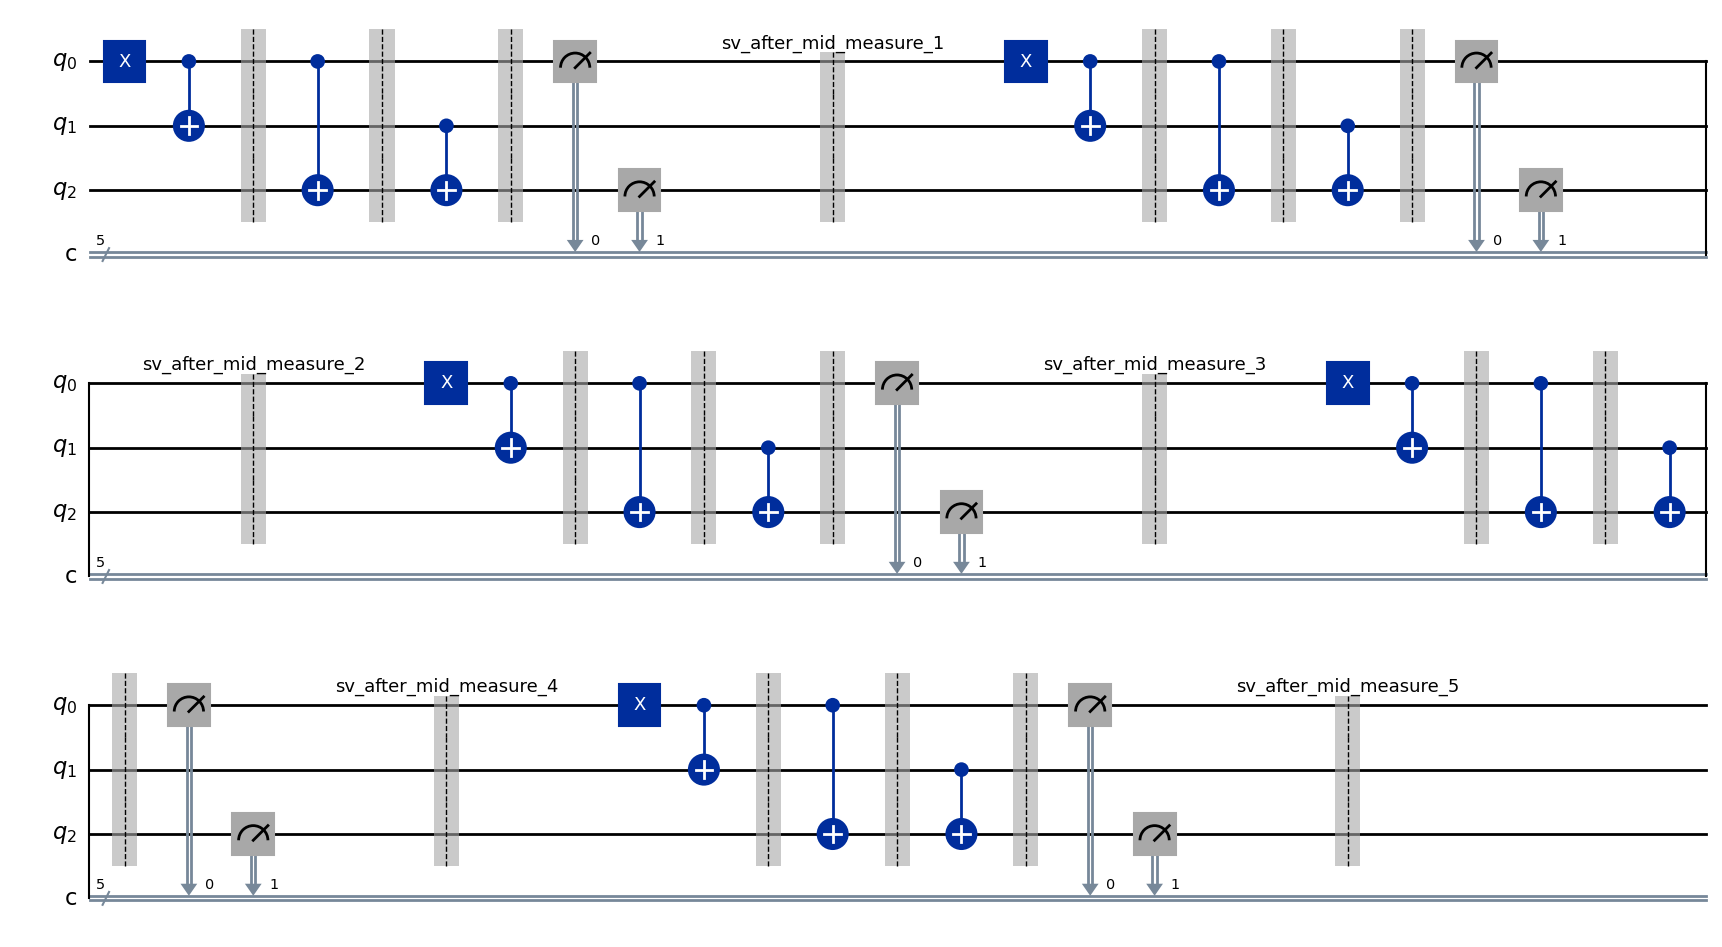

In [2]:
from qiskit import QuantumCircuit

def build_circuit(cycles, N_q=3, extra_measures=2):
    N_m = N_q + extra_measures
    qc = QuantumCircuit(N_q, N_m)

    for c in range(1, cycles+1):

        # Prepare |01>
        qc.x(0)
        qc.cx(0,1)
        qc.barrier()
        #qc.save_statevector(label=f"sv_after_entanglement_{c}")
        qc.cx(0,2)
        qc.barrier()
        #qc.save_statevector(label=f"sv_after_cx02_{c}")
        qc.cx(1,2)
        qc.barrier()
        #qc.save_statevector(label=f"sv_after_cx12_{c}")

        # Mid-cycle measurement
        qc.measure([0, N_q-1], range(extra_measures))
        qc.save_statevector(label=f"sv_after_mid_measure_{c}")
        
        # Measure
        """
        qc.barrier()  #
        qc.measure(range(N_q), range(extra_measures,N_m))
        qc.barrier()  #
        qc.x(range(N_q))  #
        """

    return qc



qc = build_circuit(cycles=5)

qc.draw('mpl')

Might need the device parameters to transpile

In [3]:
# Simulate with Aer
shots = 1
sim = AerSimulator(method="statevector")
result_orig = sim.run(qc, shots=shots).result()

orig_svs = {}
for label in result_orig.data().keys():
    orig_svs[label] = result_orig.data()[label]

counts = result_orig.get_counts()

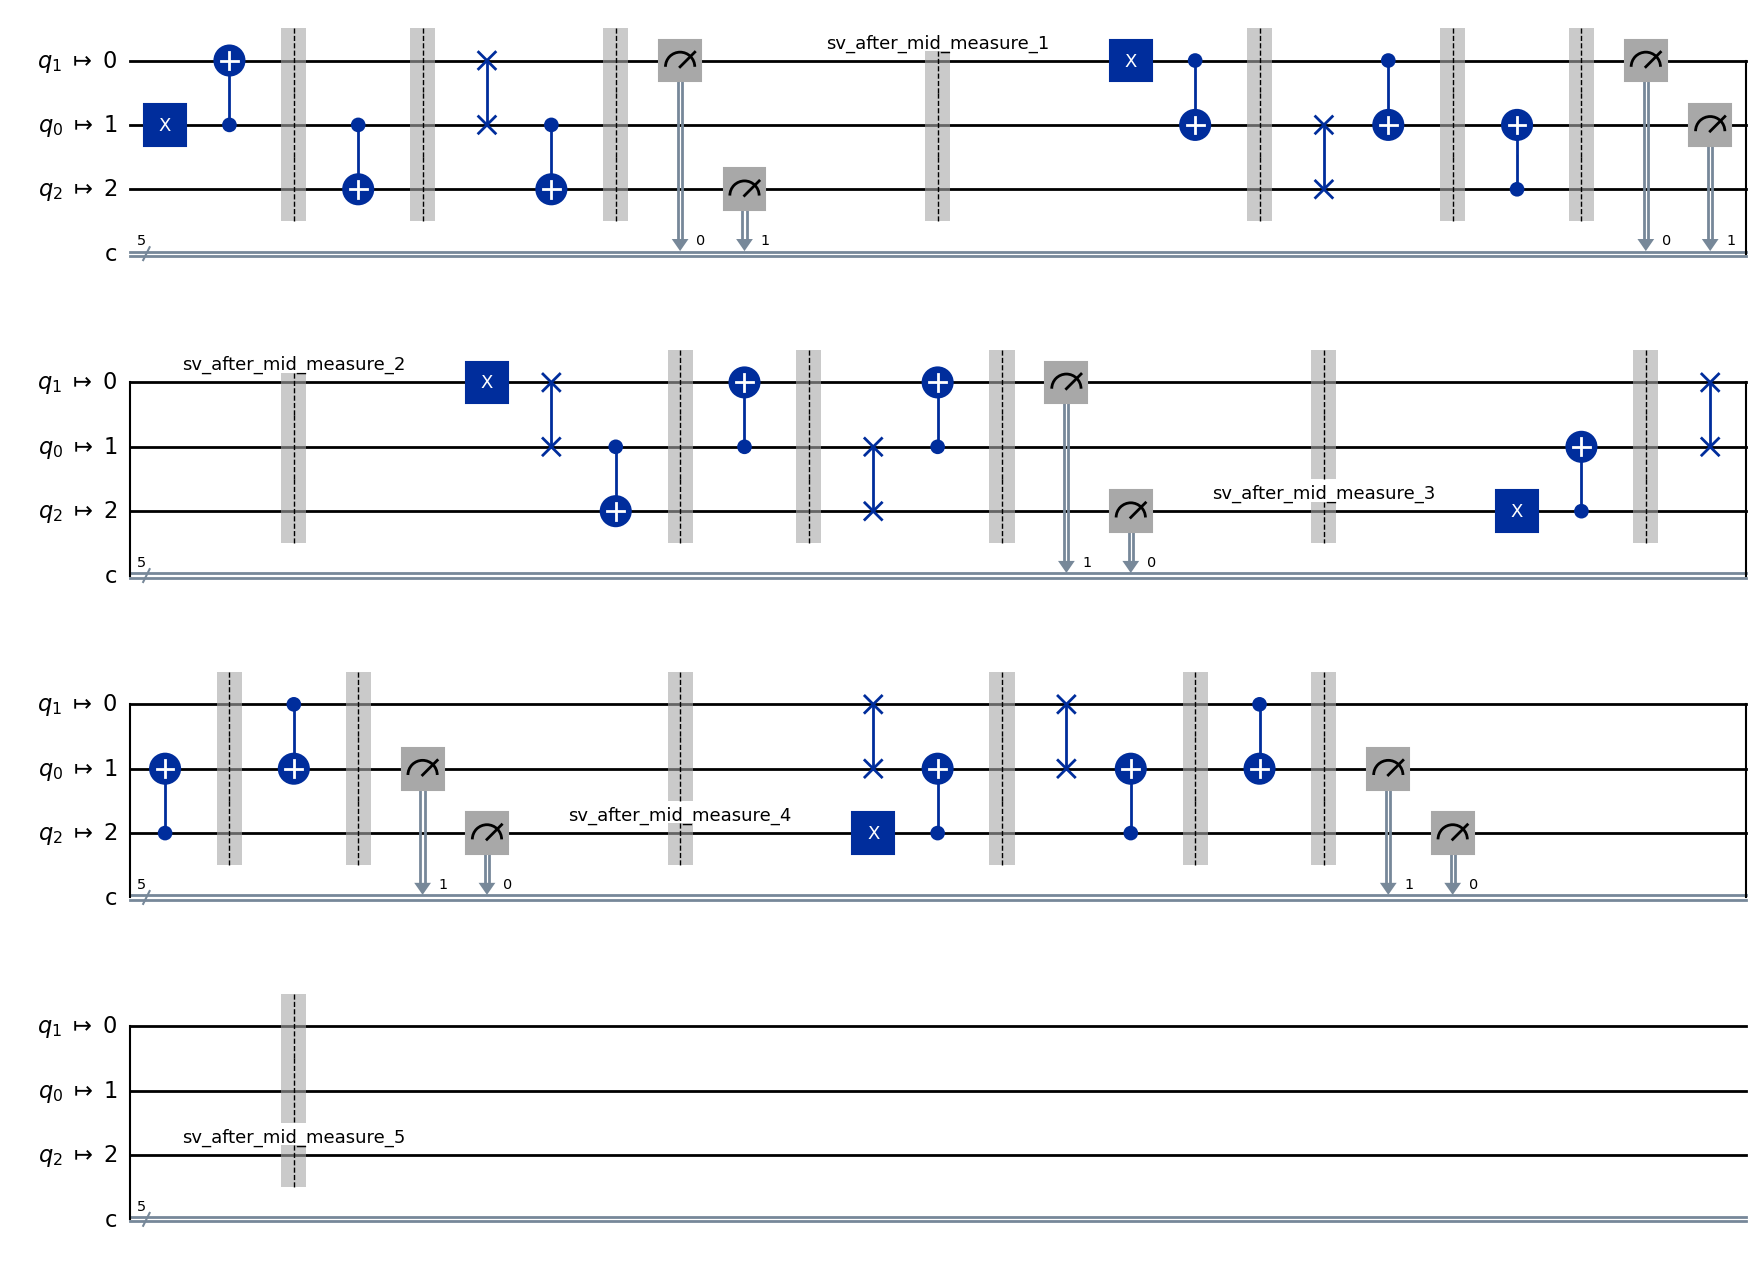

In [4]:
transpiled_circ = transpile(qc, coupling_map=[[0,1],[1,0],[1,2],[2,1]], optimization_level=2)
transpiled_circ.draw('mpl')

In [5]:
result_trans = sim.run(transpiled_circ, shots=shots).result()

trans_svs = {}
for label in result_trans.data().keys():
    trans_svs[label] = result_trans.data()[label]

counts_trans = result_trans.get_counts()

In [6]:

def sv_only(d):
    """Return dictionary filtered to contain only actual Statevector entries."""
    return {label: sv for label, sv in d.items() if isinstance(sv, Statevector)}

orig_svs_clean = sv_only(orig_svs)
trans_svs_clean = sv_only(trans_svs)


In [7]:
print('-- Before Permutation Statevector Results --')
for label in trans_svs_clean:
    print(label)
    print('Original Circuit: ', np.array(orig_svs_clean[label]))
    print('Transpilled Circuit: ',np.array(trans_svs_clean[label]))
    F = state_fidelity(orig_svs_clean[label], trans_svs_clean[label])
    print("** Fidelity ", F, "\n")


-- Before Permutation Statevector Results --
sv_after_mid_measure_1
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_2
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_3
Original Circuit:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  0.0 

sv_after_mid_measure_4
Original Circuit:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Transpilled Circuit:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_5
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1

Permutation Work   

In [8]:
def extract_save_qubit_orders(transpiled):
    """
    Return list of (label, qubit_order_list)
    where qubit_order_list gives the physical qubits used
    by that SaveStatevector instruction at that moment.
    """
    save_info = []

    for inst, qargs, cargs in transpiled.data:
        if inst.name == "save_statevector":
            label = inst.label  # read label string
            qubit_order = [transpiled.find_bit(q).index for q in qargs]
            save_info.append((label, qubit_order))

    return save_info

In [9]:
trans_save_info = extract_save_qubit_orders(transpiled_circ)
print(trans_save_info)


[('sv_after_mid_measure_1', [0, 1, 2]), ('sv_after_mid_measure_2', [0, 2, 1]), ('sv_after_mid_measure_3', [2, 1, 0]), ('sv_after_mid_measure_4', [2, 0, 1]), ('sv_after_mid_measure_5', [2, 0, 1])]


C:\Users\npace\AppData\Local\Temp\ipykernel_15228\3070367269.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in transpiled.data:


In [10]:
def permute_sv(sv, qubit_order):
    """
    sv: numpy statevector (complex array)
    qubit_order: list where qubit_order[logical] = physical qubit index
                 in the ordering used by the save instruction

    This restores the statevector into logical [0,1,2,...] order.
    """
    n = len(qubit_order)
    new_sv = np.zeros_like(sv)

    for idx in range(len(sv)):
        # physical bits in the statevector as output by Aer
        phys_bits = [(idx >> i) & 1 for i in range(n)]

        # reorder into logical order
        log_bits = [ phys_bits[qubit_order[logical]] for logical in range(n) ]

        # compute new index in logical basis ordering
        new_idx = sum(log_bits[i] << i for i in range(n))

        new_sv[new_idx] = sv[idx]

    return new_sv


In [11]:

# --- permute each statevector correctly ---
trans_permuted_svs = {}

for label, qubit_order in trans_save_info:
    sv_raw = np.array(trans_svs[label])   # raw transpiled statevector
    sv_logical = permute_sv(sv_raw, qubit_order)
    trans_permuted_svs[label] = sv_logical
    

In [12]:

for label in trans_permuted_svs:
    print(label)
    print('Original Circuit: ', np.array(orig_svs_clean[label]))
    print('Permuted Transpilled Circuit: ',trans_permuted_svs[label])
    F = state_fidelity(orig_svs_clean[label], trans_permuted_svs[label])
    print("** Fidelity ", F, "\n")



sv_after_mid_measure_1
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Permuted Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_2
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
Permuted Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_3
Original Circuit:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Permuted Transpilled Circuit:  [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_4
Original Circuit:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Permuted Transpilled Circuit:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
** Fidelity  1.0 

sv_after_mid_measure_5
Original Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Permuted Transpilled Circuit:  [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0

Original Circ Aer All clbits counts: {'00001': 1}


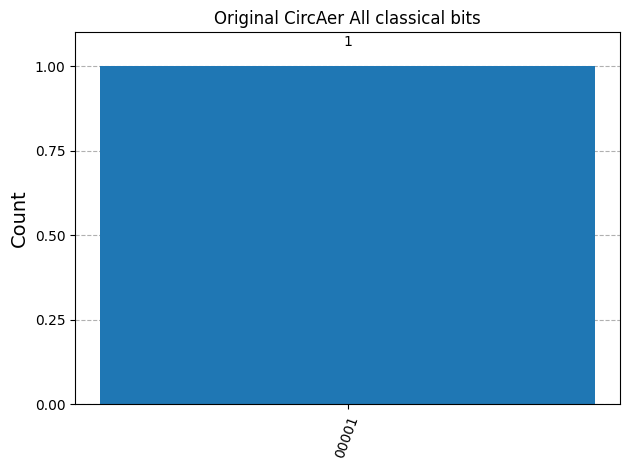

In [13]:
print("Original Circ Aer All clbits counts:", counts)
plot_histogram(counts, title="Original CircAer All classical bits")

Transpilled Circ Aer All clbits counts: {'00001': 1}


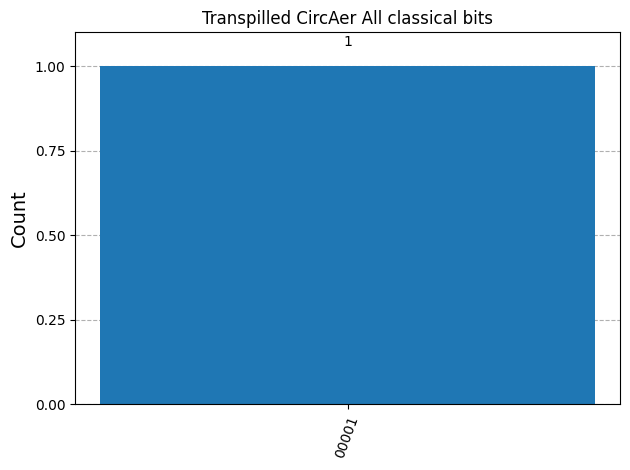

In [14]:
print("Transpilled Circ Aer All clbits counts:", counts_trans)
plot_histogram(counts_trans, title="Transpilled CircAer All classical bits")